In [1]:
%load_ext autoreload
%autoreload 2

This notebook requires a pair of untransformed and annotation-based transformed embeddings. The snakemake worflow in this repository contains rules for generating these embedding pairs with UMAP for FAUST annotations (`{name}_embedding_output.parquet` ). An example pair can be generated via,

```bash
snakemake --cores all \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap.parquet \
    data/mair-2022-ismb/TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595_umap_annotated.parquet
```

which downloads [sample annotations](https://figshare.com/articles/dataset/ISMB_BioVis_2022_Data/20301639) from figshare and executes the embedding rules automatically.


In [2]:
import pathlib

import jscatter
import metrics  # local module
import numpy as np
import pandas as pd
import seaborn as sns

data_dir = pathlib.Path.cwd() / ".." / "data" / "mair-2022-ismb"
name = "TISSUE_138_samples_FM96_OM138_035_CD45_live_fcs_110595"

raw = pd.read_parquet(data_dir / f"{name}_umap_annotated.parquet")
annotated = pd.read_parquet(data_dir / f"{name}_umap.parquet")

# point–point comparison (*k* 1–10)

- Jaccard distance: $\frac{ | A \cap B | }{ | A \cup B | } = \frac{ | A \cap B | }{ | A | + | B | - | A \cap B | }$


In [3]:
pairwise_distances = {
    k: metrics.jaccard_pointwise(annotated[["x", "y"]], raw[["x", "y"]], k=k)
    for k in (3, 5, 10, 20, 30, 40, 60, 99)
}

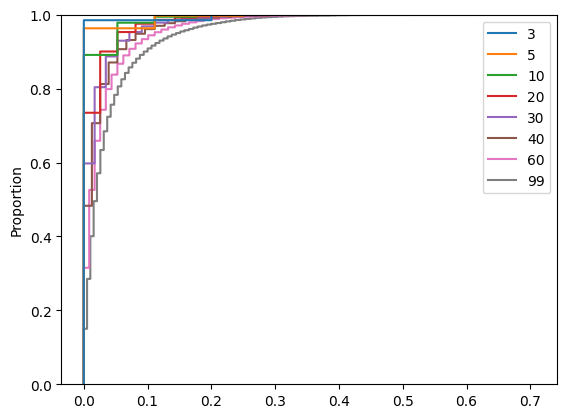

In [4]:
sns.ecdfplot(pairwise_distances);

# label–point comparison

- "group-wise" Jaccard distance: $\frac{\bigcup_{i \in I} A_i \cap B_i}{\bigcup_{i \in I} A_i \cup B_i}$, where $I$ is a set of points with a given label

In [5]:
groupwise_distances = {
    k: metrics.jaccard_groupwise(
        annotated[["x", "y"]], raw[["x", "y"]], raw["cellType"], k=k
    )
    for k in (1, 2, 3, 5, 10, 20, 30)
}

In [6]:
groupwise_distances[20].head()

,label,score
0,0_0_0_0_0,0.064586
1,CD4+CD8+CD3+CD45RA+CD27+CD19-CD103-CD28+CD69+P...,0.012346
2,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103+CD28+CD69+P...,0.038168
3,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103+CD28+CD69+P...,0.027491
4,CD4+CD8+CD3+CD45RA-CD27+CD19-CD103-CD28+CD69+P...,0.005739


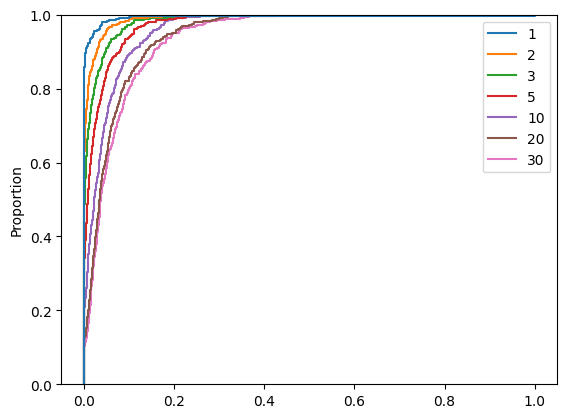

In [7]:
sns.ecdfplot({k: v["score"] for k, v in groupwise_distances.items()});

- Alternatively, view the distribution/summary of Jaccard distances for all points in a group

In [8]:
pointwise_ave_distances = {
    k: metrics.jaccard_pointwise_average(
        annotated[["x", "y"]], raw[["x", "y"]], raw["cellType"], k=k
    )
    for k in (1, 2, 3, 5, 10, 20, 30)
}

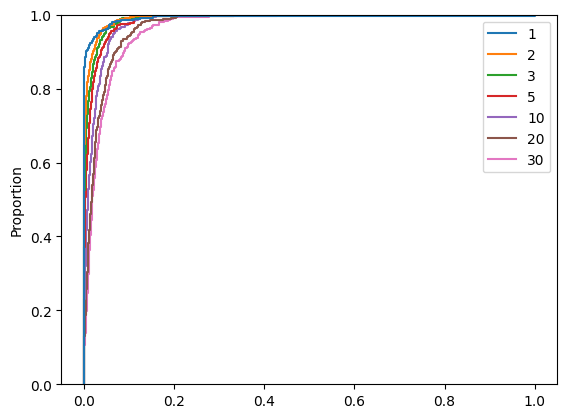

In [9]:
sns.ecdfplot({k: v["score"] for k, v in pointwise_ave_distances.items()});

# label–label comparision

For each point $i$ given $M$ labels,
   - Find *k*NN
   - Count the label occurence of each neighbor in label counts vector $counts_i = (c_1, c_2, ..., c_{M-1}, c_M)$
  
Compare the label counts vector for point $i$ between both datasets (cosine similarity)

In [10]:
# TODO: profile and optimize implementation

k = 100

dist_annotated = metrics.count_labels(annotated[["x", "y"]], raw["cellType"], k=k)
dist_raw = metrics.count_labels(raw[["x", "y"]], raw["cellType"], k=k)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110584/110584 [00:52<00:00, 2103.59it/s]


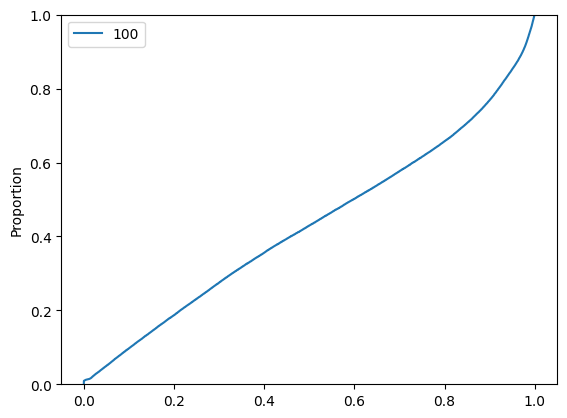

In [11]:
import numpy.linalg as nplg
import numpy.typing as npt


def rowise_cosine_similarity(X0: npt.ArrayLike, X1: npt.ArrayLike):
    """Computes the cosine similary per row of two equally shaped 2D matrices."""
    return np.sum(X0 * X1, axis=1) / (nplg.norm(X0, axis=1) * nplg.norm(X1, axis=1))


point_label_distances = rowise_cosine_similarity(dist_annotated, dist_raw)
sns.ecdfplot({k: point_label_distances});

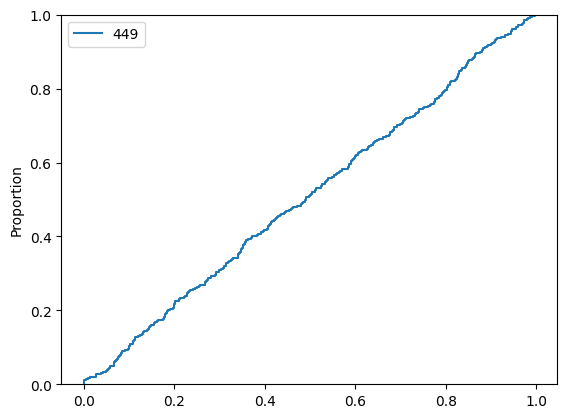

In [12]:
label_label_distances = rowise_cosine_similarity(
    pd.DataFrame(dist_annotated, index=raw.cellType).groupby("cellType").mean(),
    pd.DataFrame(dist_raw, index=raw.cellType).groupby("cellType").mean(),
)
sns.ecdfplot({len(label_label_distances): label_label_distances});

# embed with distance metrics

In [13]:
import colors

# add distance metrics to dataframes
annotated["dist"] = point_label_distances
raw["dist"] = point_label_distances
annotated["label_dist"] = raw.cellType.map(label_label_distances)
raw["label_dist"] = raw.cellType.map(label_label_distances)


view_config = dict(
    x="x", y="y", background_color="black", axes=False, opacity_unselected=0.05
)

compose_config = dict(sync_selection=True, sync_hover=True, row_height=640, rows=2)

color_map = (
    [colors.gray_dark]
    + colors.glasbey_light
    + colors.glasbey_light
    + colors.glasbey_light
)
view_conf_labels = {"color_by": "cellType", "color_map": color_map, **view_config}
view_conf_distances = {"color_by": "label_dist", **view_config}


jscatter.compose(
    [
        jscatter.Scatter(data=annotated, **view_conf_labels),
        jscatter.Scatter(data=raw, **view_conf_labels),
        jscatter.Scatter(data=annotated, **view_conf_distances),
        jscatter.Scatter(data=raw, **view_conf_distances),
    ],
    **compose_config
)

GridBox(children=(HBox(children=(VBox(children=(Button(button_style='primary', icon='arrows', layout=Layout(wi…